 approximate bayesian computation

In [1]:
import sys, os
import copy
join = lambda *x: os.path.abspath(os.path.join(*x))
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import scipy.stats

import pili
import parameters
import _fj
import fjanalysis
import twanalyse
import rtw
import sobol
import abcimplement
from abcimplement import mirror, mirrorpts


In [2]:
verbose = False
style = {}


In [3]:
notedir = os.getcwd()
root = pili.root
# candidate to compare against
# simdir = join(root, "../run/5bfc8b9/cluster/mc4d")
simdir = join(root, "../run/825bd8f/cluster/mc4d")



In [4]:
# load fanjin data
all_idx, ltrs = _fj.slicehelper.load_linearized_trs("all")
reference_idx = _fj.load_subset_idx()
subsets = list(reference_idx.keys())


100%|██████████| 3113/3113 [00:01<00:00, 2338.97it/s]


In [5]:
mc4d = {}
mc4d["simdir"] = simdir
objectives = ['lvel.mean', 'deviation.var', 'qhat.estimate', 'ahat.estimate']
mc4d["objectives"] = objectives
abcimplement.load_problem_simulation(mc4d)
lookup = mc4d["lookup"]
problem = mc4d["problem"]
lduid = mc4d["lduid"]


nan found in lvel.mean. filtering 1 samples
nan found in deviation.var. filtering 1 samples
nan found in qhat.estimate. filtering 1 samples
nan found in ahat.estimate. filtering 1 samples
failed: Counter({'step_condition': 1})
filtered out 1/10000 samples
loaded data from  /home/dan/usb_twitching/run/825bd8f/cluster/mc4d


In [6]:
# velocity similarity scores are summary statistics that are 
# already computed against the reference data
# We need to handle them differently
ks_scores = ['fanjin.%s.ks_statistic' % subset for subset in reference_idx.keys()]

print("objectives", objectives)
_data =  sobol.collect_obs(lookup, lduid, objectives, objectives)
missing = sobol.check_missing(lookup, _data)
print(missing)


objectives ['lvel.mean', 'deviation.var', 'qhat.estimate', 'ahat.estimate']
None


In [7]:
refdf = fjanalysis.compute_reference_data(ltrs, reference_idx, objectives)


/home/dan/usb_twitching/pili/src/analysis/twanalyse.py:957: RuntimeWarning: invalid value encountered in true_divide
  norm_dy = dy/np.linalg.norm(dy, axis=1)[:,np.newaxis]


In [8]:
# construct data frame with parameters and objectives
params = mc4d["data"].paramsdf(objectives)
params

,uid,dwell_time,pilivar,anchor_angle_smoothing_fraction,k_spawn,lvel.mean,deviation.var,qhat.estimate,ahat.estimate
0,_u_Ggkp1Yqv,0.277358,2.972168,0.636124,4.200050,0.111104,0.612706,0.444574,0.332158
1,_u_kO2vLVPq,2.290156,13.458395,0.982386,4.910491,0.220407,0.485135,0.682960,0.374695
2,_u_f07f6w1e,1.152016,4.898614,0.791042,3.650944,0.172579,0.567951,0.602694,0.367633
3,_u_5x7UXRa3,2.895285,9.772801,0.601714,5.800258,0.187449,0.622302,0.629465,0.321893
4,_u_xD799B4g,2.235726,14.043213,0.804412,2.256907,0.109917,0.196990,0.713616,0.307400
...,...,...,...,...,...,...,...,...,...
9994,_u_q7T1w8MB,0.517194,6.952505,0.678124,6.057240,0.179546,0.287126,0.610588,0.339045
9995,_u_pR5aO8wh,2.703825,12.438112,0.360815,1.686277,0.067876,0.157684,0.653821,0.226175
9996,_u_gYAqb1Pd,2.004187,2.643347,0.428564,4.048677,0.121132,0.855941,0.531354,0.287960
9997,_u_4q0YoFeA,0.810165,13.788433,0.252809,5.810044,0.090522,0.110491,0.607698,0.201815


In [9]:
# similar for ks_statistic
_parlist = list(zip(problem["names"],  zip(*[lookup[1][_u] for _u in lookup[0]])))
_col = {k:v for k, v in _parlist}
_data =  sobol.collect_obs(lookup, lduid, ks_scores, ks_scores)
_col.update({name:_data[name] for name in ks_scores})
ksparams = pd.DataFrame(_col)

for score_subset in ks_scores:
    print("{} min = {:.4f}".format(score_subset, ksparams[score_subset].min()))


fanjin.candidate.ks_statistic min = 0.1817
fanjin.top.ks_statistic min = 0.0956
fanjin.half.ks_statistic min = 0.0969
fanjin.median.ks_statistic min = 0.0382
fanjin.walking.ks_statistic min = 0.0708


In [10]:
# plot the sampling distribution (uniform random)
# any projection will do
if verbose:
    plt.rcParams.update({'text.usetex': False})
    fig, ax = plt.subplots(figsize=(5,5))
    sns.scatterplot(params["pilivar"], params["anchor_angle_smoothing_fraction"], 
        hue=params["ahat.estimate"], ax=ax)


In [11]:
# Implement rejection ABC
# we can construct an approximate posterior distribution for 
# 1. simulated reference
# 2. fanjin data subsets
from abcimplement import rejection_abc
parnames = problem["names"]
bounds = problem["bounds"]

# select the "top" subset as the preferred reference data
subset = "top"
reference = refdf.iloc[1]


In [12]:
# construct a dictionary of dataframes, one for each summary statistic we will use
accept  = {}
N = 200
for objective in objectives:
    statdf = params[parnames+[objective]]
    accepted = rejection_abc(statdf, [objective], reference, N)
    # max_score = accepted.iloc[N-1]["score"]
    # print("max score is", max_score)
    accept[objective] = accepted

# add the lvel similarity stat
top_ks = "fanjin.top.ks_statistic"
ks_statdf = ksparams[parnames+[top_ks]]
accept[top_ks] = rejection_abc(ks_statdf, [top_ks], reference, N)



['lvel.mean']
(9999, 1)
['lvel.mean']
N = 200, delta = 0.0023010600373943035, target = [0.07223161]
['deviation.var']
(9999, 1)
['deviation.var']
N = 200, delta = 0.022738550548110026, target = [0.70864216]
['qhat.estimate']
(9999, 1)
['qhat.estimate']
N = 200, delta = 0.002859086534804045, target = [0.57221674]
['ahat.estimate']
(9999, 1)
['ahat.estimate']
N = 200, delta = 0.011243760546231815, target = [0.08248354]
['fanjin.top.ks_statistic']
(9999, 1)
['fanjin.top.ks_statistic']
N = 200, delta = 0.1948867758811624, target = [0.]


/home/dan/usb_twitching/pili/src/analysis/abcimplement.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  statdf["score"] = score


plotting pairplots for  ['lvel.mean', 'deviation.var', 'qhat.estimate', 'ahat.estimate', 'fanjin.top.ks_statistic']


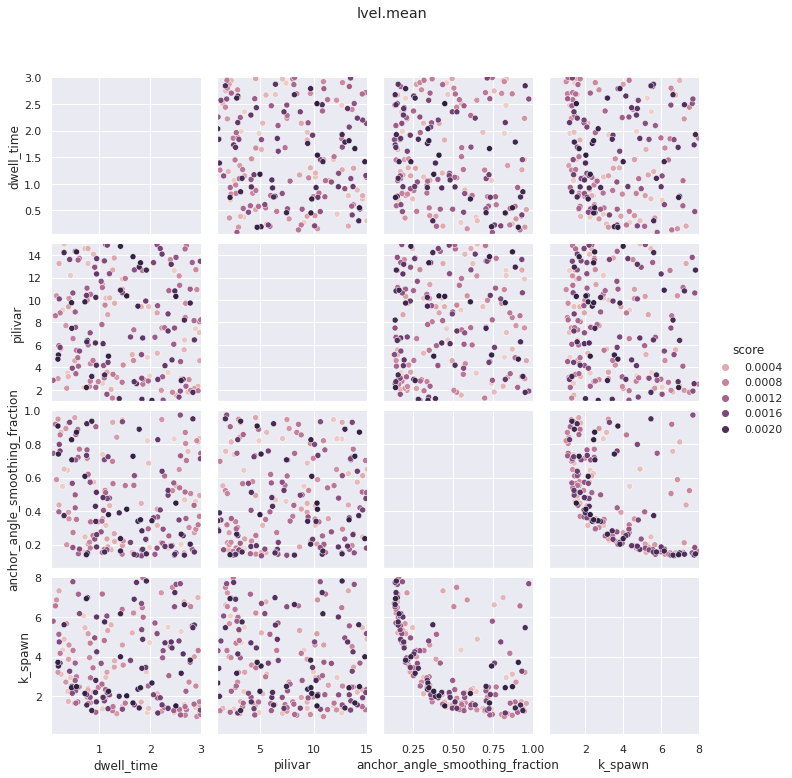

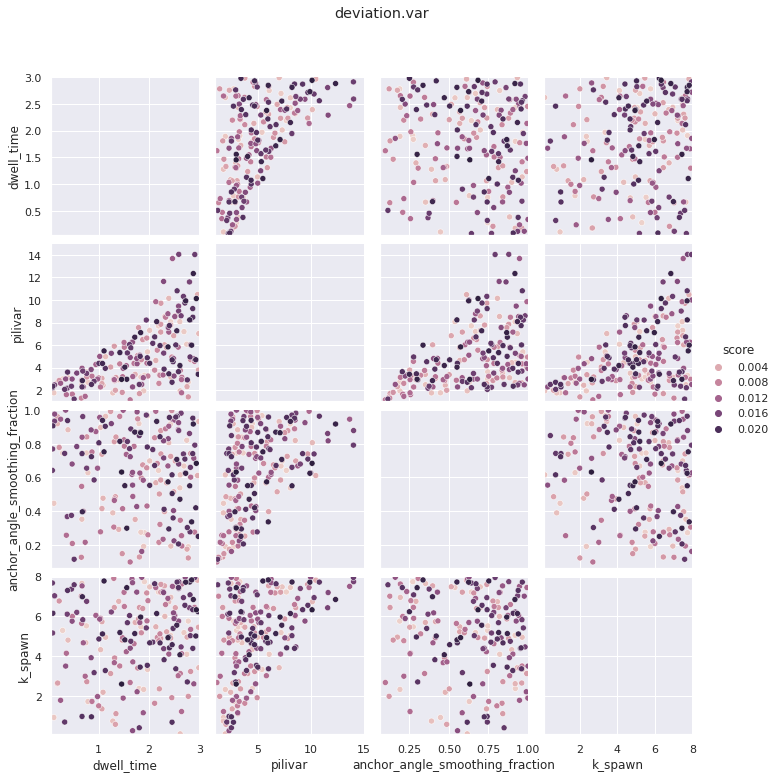

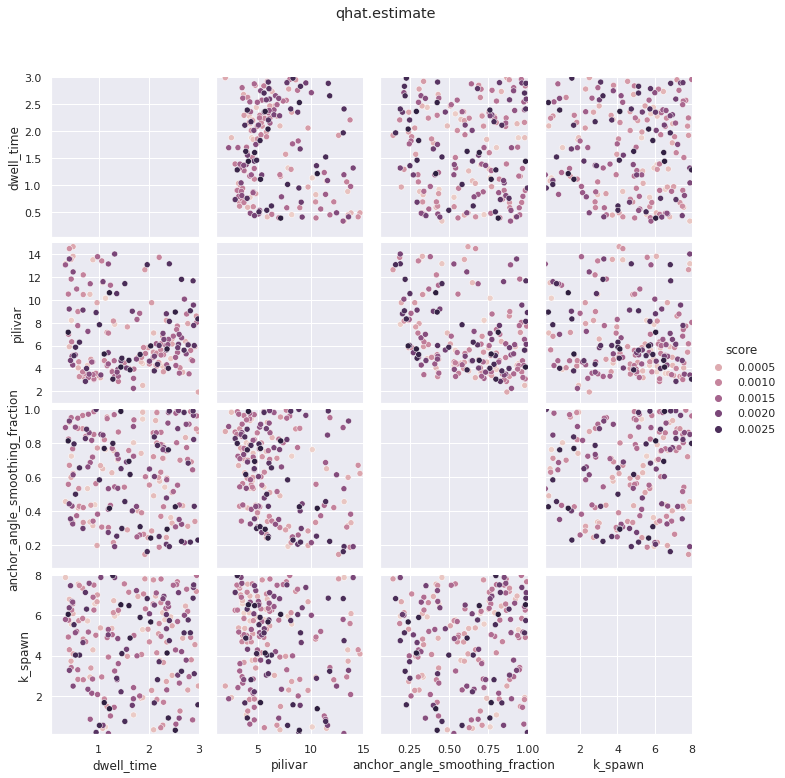

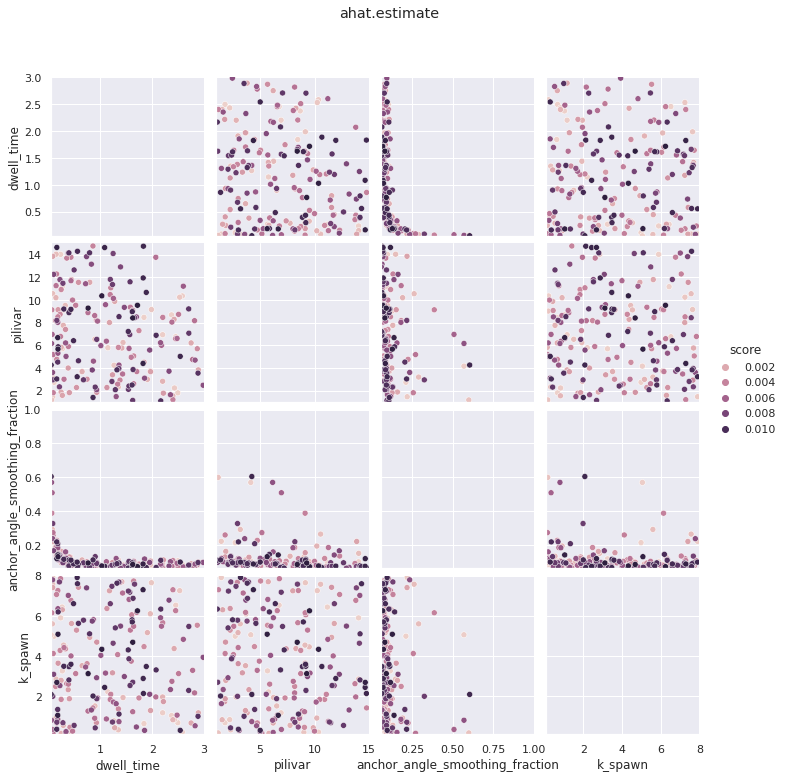

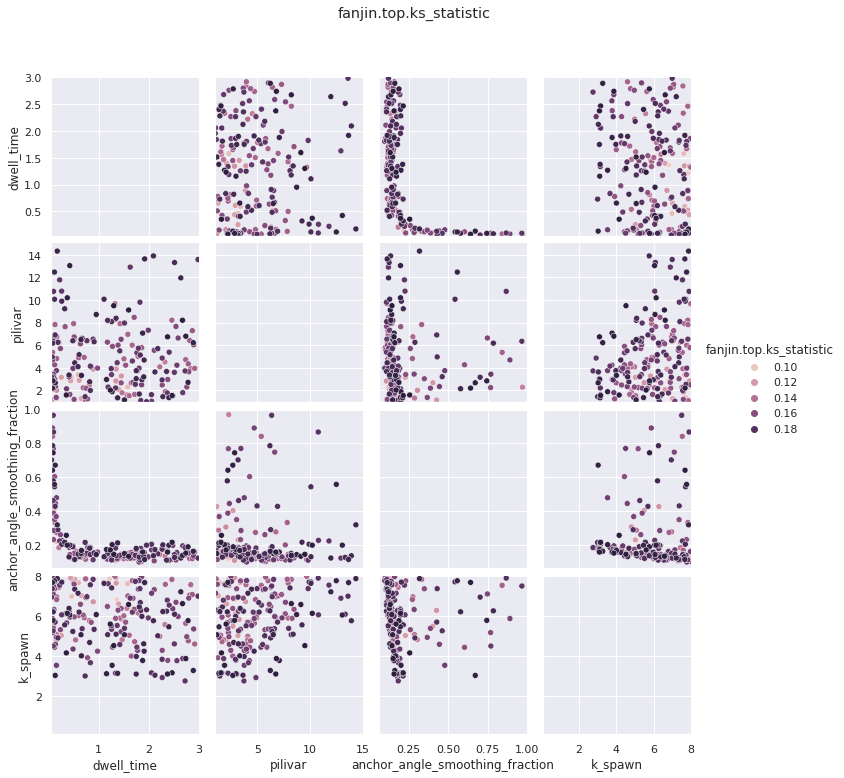

In [13]:
# show the rejection_abc results in all pairs of dimensions
n = len(problem["names"])
plt.rcParams.update({'text.usetex': False})
sns.set(rc={'figure.figsize':(20,20)})
print("plotting pairplots for ", list(accept.keys()))
for objective, accepted in accept.items():
    # print(objective)
    is_lvel = objective.startswith("fanjin")
    if is_lvel:
        data  = accepted[parnames+[objective]] 
        hue = objective
    else:
        data  = accepted[parnames+["score"]] 
        hue = "score" 
    g = sns.pairplot(data, hue=hue, **style)
    g.fig.suptitle(objective, y=1.08) # y= some height>1
    for i in range(n):
        for j in range(n):
            if i==j:
                continue
            _xlim = bounds[j]
            _ylim = bounds[i]
            g.axes[i,j].set_xlim(_xlim)
            g.axes[i,j].set_ylim(_ylim)



anchor estimate 1 0.1170436586856583
anchor estimate 2 0.22103943483483832


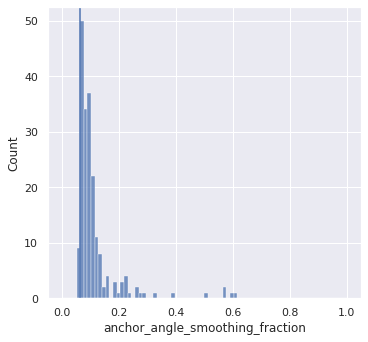

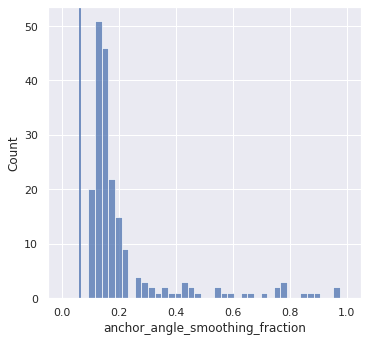

In [14]:
# pull estimates for anchor parameter for "top" from ks_statistic and activity
projection = ["anchor_angle_smoothing_fraction", "pilivar"]
p1, p2 = projection
xlim = (0,1)
_p1distrib = accept["ahat.estimate"][p1]
fig = plt.figure(figsize=(5,5))
ax= sns.histplot(_p1distrib, binrange=xlim)
ax.axvline(0.0625)
print('anchor estimate 1', np.mean(_p1distrib))

_p1distrib = accept["fanjin.top.ks_statistic"][p1]
fig = plt.figure(figsize=(5,5))
ax= sns.histplot(_p1distrib, binrange=xlim)
ax.axvline(0.0625)
print('anchor estimate 2', np.mean(_p1distrib))


In [15]:
# based on sobol, project this dataset onto pilivar/anchor and do 
# rejection ABC to obtain posterior distribution
N = 200
objective = "ahat.estimate"
projection = ["anchor_angle_smoothing_fraction", "pilivar"]
# params[projection+"ahat.estimate"]

statdf = params[parnames+[objective]]
postactive = rejection_abc(statdf, ["ahat.estimate"], reference, N)
# ahat_accepted = postactive[projection+["score"]]

['ahat.estimate']
(9999, 1)
['ahat.estimate']
N = 200, delta = 0.011243760546231815, target = [0.08248354]


/home/dan/usb_twitching/pili/src/analysis/abcimplement.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  statdf["score"] = score


['ahat.estimate']
(9999, 1)
['ahat.estimate']
N = 200, delta = 0.008758155595260234, target = [0.10862537]


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


['ahat.estimate']
(9999, 1)
['ahat.estimate']
N = 200, delta = 0.011243760546231815, target = [0.08248354]


/home/dan/usb_twitching/pili/src/analysis/abcimplement.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  statdf["score"] = score
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


['ahat.estimate']
(9999, 1)
['ahat.estimate']
N = 200, delta = 0.03603170945224269, target = [0.03630491]


/home/dan/usb_twitching/pili/src/analysis/abcimplement.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  statdf["score"] = score


['ahat.estimate']
(9999, 1)
['ahat.estimate']
N = 200, delta = 0.038368728540705624, target = [0.03396789]


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/dan/usb_twitching/pili/src/analysis/abcimplement.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  statdf["score"] = score
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  

['ahat.estimate']
(9999, 1)
['ahat.estimate']
N = 200, delta = 0.21031894247241167, target = [0.6371117]


/home/dan/usb_twitching/pili/src/analysis/abcimplement.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  statdf["score"] = score
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


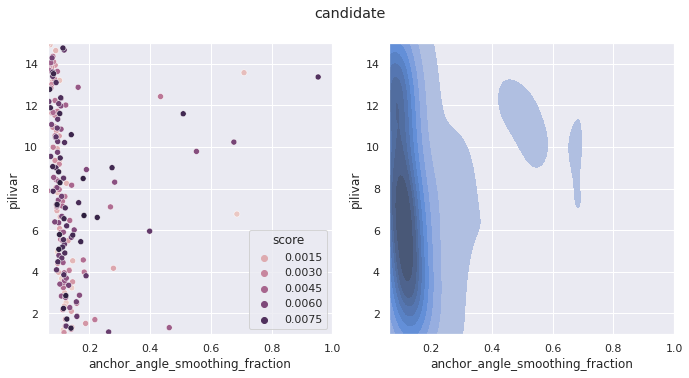

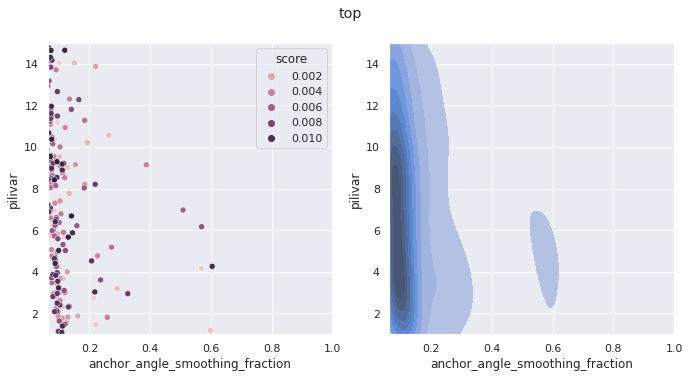

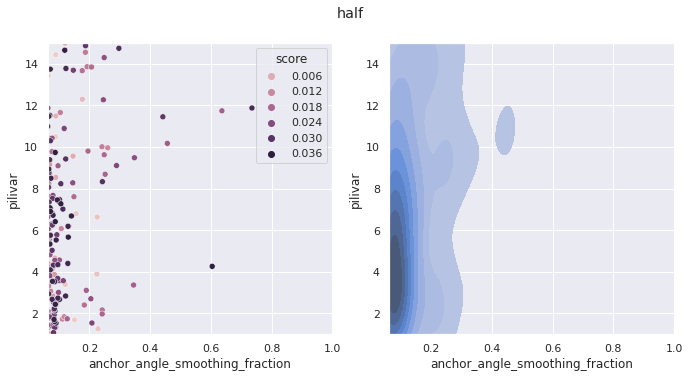

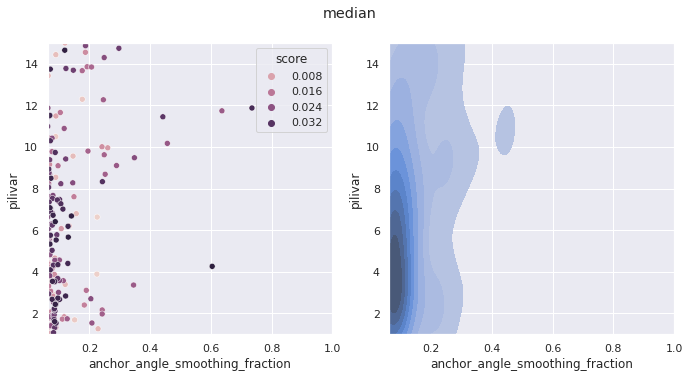

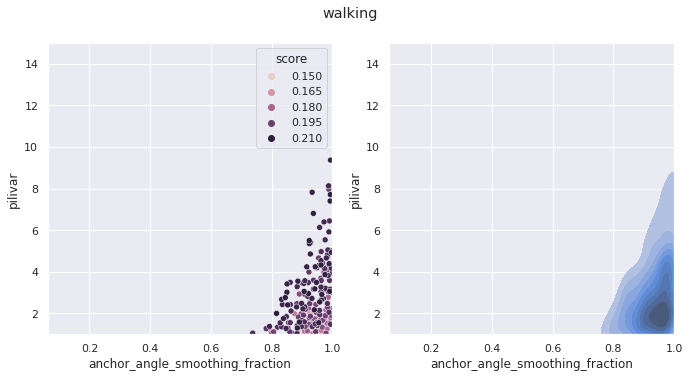

In [16]:
# plot the rejection_abc for activity statistic for each subset of the data
def plot_activity(par_accepted, projection, problem):
    parnames = problem["names"]
    fig, axes = plt.subplots(1,2,figsize=(10,5))
    ax1, ax2 = axes
    x, y = projection
    ix, iy = [parnames.index(name) for name in projection]
    sns.set(rc={'figure.figsize':(5,5)})
    ax1 = sns.scatterplot(data=par_accepted, x=x, y=y, hue="score", ax=ax1)
    ax1.set_xlim(bounds[ix])
    ax1.set_ylim(bounds[iy])
    #
    X, Y = par_accepted[x], par_accepted[y]
    ax2 = sns.kdeplot(X,Y, fill=True, ax=ax2)
    ax2.set_xlim(bounds[ix])
    ax2.set_ylim(bounds[iy])
    return fig, axes
    
N = 200
for i, subset in enumerate(subsets):
    _reference = refdf.iloc[i]
    statdf = params[parnames+[objective]]
    post = rejection_abc(statdf, ["ahat.estimate"], _reference, N)
    ahat_accepted = post[projection+["score"]]
    fig, axes = plot_activity(ahat_accepted, projection, problem)
    fig.suptitle(subset)



 The shape of the kernel is not that important but the bandwidth is very important.


In [17]:
# ---------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------
# TODO move kernel study to a different note book ... (?)

# # plot the 1d projection of the distribution onto anchor parameter
# # so that we can test sklearn kernel selection
# anchor_parameter = projection[0]
# activitydf = accept["ahat.estimate"]
# activity = activitydf[anchor_parameter].to_numpy()
# sns.histplot(activity, binrange=(0,1.0))


In [18]:
# statsmodels is easier to use than sklearn and gives similar results
use_sklearn = False 
if use_sklearn:
    # https://scikit-learn.org/stable/modules/density.html
    # https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/
    x = activity
    from sklearn.neighbors import KernelDensity
    from sklearn.model_selection import GridSearchCV
    # https://scikit-learn.org/stable/modules/grid_search.html#grid-search
    import warnings
    # warnings.filterwarnings("ignore", category=UserWarning)
    # warnings.filterwarnings("ignore")
    # some global structure to allow use to both set bandwidths and let them be estimated
    bw_space_res = 40
    bw_settings = {
        "pilivar": {
            "estimate": True,
            "set": 5.0,
            "geom": np.geomspace(0.1,10.0,bw_space_res)
            },
        "anchor_angle_smoothing_fraction": {
            "estimate": True,
            "set": 0.01,
            "geom":np.geomspace(0.001,0.5,bw_space_res)
            },
        }
    # allow the notebook to vary this
    mod_bw_settings = copy.deepcopy(bw_settings)

def bandwidth_xvalidate(x, bw_space=None, bounds=None, mirror_boundaries=True):
    if mirror_boundaries:
        _x = mirror(x, bounds)
    else:
        _x = x
    if bw_space is None:
        bw_space = np.linspace(np.std(x)/2, (np.max(x)-np.min(x))/2, num=20)
    print("searching bw in range ", bw_space[0], bw_space[-1])
    grid = GridSearchCV(KernelDensity(kernel="epanechnikov"),
                        {'bandwidth': bw_space},
                        cv=20) # 20-fold cross-validation
    grid.fit(_x[:, None])
    return grid

def kernel_pdf(par_accepted, xlim, bw_space=None, estimate_bandwidth=True, mirror_boundaries=True):
    x_grid = np.linspace(xlim[0], xlim[1], 200)
    # 
    if estimate_bandwidth:
        grid = bandwidth_xvalidate(par_accepted, bw_space=bw_space, bounds=xlim, 
            mirror_boundaries=mirror_boundaries)
        print("best", grid.best_params_['bandwidth'])
        kde = grid.best_estimator_
    #
    else:
        if mirror_boundaries:
            par_accepted = mirror(par_accepted, xlim)
        bw = bw_space
        print("set bandwidth", bw)
        kde = KernelDensity(kernel='epanechnikov', bandwidth=bw)
        kde.fit(par_accepted[:, None])
    #
    pdf = np.exp(kde.score_samples(x_grid[:, None]))
    if mirror_boundaries:
        pdf *= 3
    return x_grid, pdf, kde.bandwidth

if use_sklearn:
    estimate_bandwidth = True
    mirror_boundaries = True
    for par in projection:
        print("projection axis ", par)
        ix = parnames.index(par)
        par_accepted = accept["ahat.estimate"][par].to_numpy()
        xlim = problem["bounds"][ix]
        bw_setting = bw_settings[par]
        estimate = bw_setting["estimate"]
        bw_space = bw_setting["geom"] if estimate else bw_setting["set"]
        x_grid, pdf, bandwidth = kernel_pdf(par_accepted.copy(), xlim, bw_space=bw_space,
            estimate_bandwidth=bw_setting["estimate"], mirror_boundaries=False)
        x_grid, m_pdf, m_bandwidth = kernel_pdf(par_accepted.copy(), xlim, bw_space=bw_space,
            estimate_bandwidth=bw_setting["estimate"], mirror_boundaries=True)
        mod_bw_settings[par]["set"] = m_bandwidth
        
        fig, ax = plt.subplots()
        ax.plot(x_grid, pdf, linewidth=3, alpha=0.5, label='bw=%.4f' % bandwidth)
        ax.plot(x_grid, m_pdf, linewidth=3, alpha=0.5, label='mirror bw=%.4f' % m_bandwidth)
        ax.set_ylim(bottom=0.0)
        ax.legend(loc='lower right')
        ax.set_title(par)
        plt.show()


In [19]:
# tryout statsmodels for multivariate KDE
import statsmodels.api as sm
ix, iy = [parnames.index(name) for name in projection]
acc = accept["ahat.estimate"]
data = [acc[par].to_numpy() for par in projection]
bw_estimate = sm.nonparametric.KDEMultivariate(data=data, var_type='cc', 
    bw='cv_ls')
    
# mirror the data in the yaxis at the top and bottom
m_data = mirrorpts(data, bounds[iy])
dens = sm.nonparametric.KDEMultivariate(data=m_data, var_type='cc', 
    bw='normal_reference')
# use bandwidth estimate from un-mirrored data
dens.bw = bw_estimate.bw
print("statsmodels least squares cross validation bandwidth estimate")
print("bw", dens.bw)


statsmodels least squares cross validation bandwidth estimate
bw [0.00545344 0.49740232]


In [20]:
# setup control parameters and grid 
N = 200
res = 100
ss = ["ahat.estimate"]
projection = ["anchor_angle_smoothing_fraction", "pilivar"]
ix, iy = [parnames.index(par) for par in projection]
xlim, ylim = bounds[ix], bounds[iy]
anchor =  np.linspace(*xlim, num=res)
pilivar =  np.linspace(*ylim, num=res)
pardata = [anchor, pilivar]


In [21]:
# accepted = rejection_abc(statdf, [objective], reference, N)
    # statdf = params[parnames+[objective]]
statdf, statref = abcimplement.regularise_stats(params, reference, objectives)
_acc = rejection_abc(statdf, ss, reference, N, ss_component=True)


0.0702688796044588
0.31113147275630193
0.1343752361814738
0.09403116839649117
['ahat.estimate']
(9999, 1)
['ahat.estimate']
N = 200, delta = 0.6867998723053954, target = [0.08248354]


In [22]:
llacc = abcimplement.llregression(_acc, reference, ss, projection)
llacc


max accepted 0.6867998723053954


,uid,dwell_time,pilivar,anchor_angle_smoothing_fraction,k_spawn,lvel.mean,deviation.var,qhat.estimate,ahat.estimate,score,s0,weight
2472,_u_xoqEd7C3,0.051843,14.841108,0.186998,1.719385,0.029671,0.194284,1.336925,0.078330,0.004153,-0.004153,1.091981
6412,_u_0HY54kBH,0.109368,8.181909,0.105588,0.760119,0.024629,0.376570,0.943546,0.067279,0.015205,-0.015205,1.091486
6338,_u_39zWeqzJ,0.321406,1.892291,0.068584,0.969261,0.043197,1.233796,1.047862,0.100282,0.017798,0.017798,1.091288
6648,_u_rCKdKQjh,0.053591,9.358616,0.121576,3.170234,0.061444,0.274346,3.139049,0.063620,0.018864,-0.018864,1.091197
2332,_u_FQ9rIHh7,0.097793,9.284087,0.068707,2.825736,0.037825,0.256784,2.284099,0.052340,0.030143,-0.030143,1.089918
...,...,...,...,...,...,...,...,...,...,...,...,...
5165,_u_1jB4OxuS,0.183448,7.790057,0.137544,5.083550,0.357931,0.570342,2.156662,0.760338,0.677855,0.677855,0.028261
1568,_u_sTRb6oMa,0.178577,8.807350,0.147882,1.045740,0.082371,0.508090,0.628456,0.761220,0.678737,0.678737,0.025490
7081,_u_PRRN2Hff,0.161297,16.769520,0.125993,2.684515,0.074493,0.276509,0.670180,0.762083,0.679599,0.679599,0.022777
96,_u_JylRuSZN,0.051948,6.405316,0.611389,2.086445,0.173446,0.936012,0.596596,0.766300,0.683816,0.683816,0.009468


Text(0.5, 1.0, 'local linear regression')

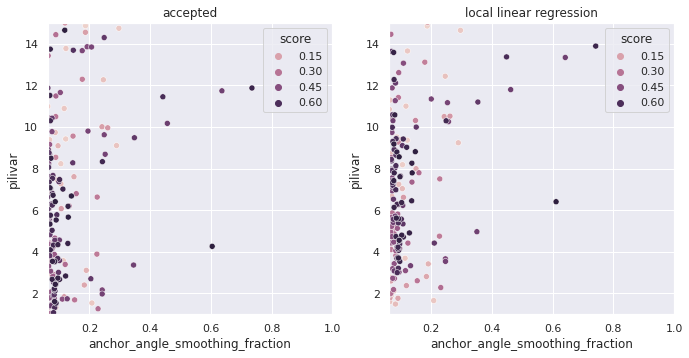

In [23]:
# scatter side by side
fig, axes = plt.subplots(1,2,figsize=(10,5))
p1, p2 = projection
#
ax = axes[0]
ax = sns.scatterplot(data=_acc, x=p1, y=p2, hue="score", ax=ax)
ax.set_xlim(bounds[ix])
ax.set_ylim(bounds[iy])
ax.set_title("accepted")
#
ax = axes[1]
ax = sns.scatterplot(data=llacc, x=p1, y=p2, hue="score", ax=ax)
ax.set_xlim(bounds[ix])
ax.set_ylim(bounds[iy])
ax.set_title("local linear regression")


In [24]:
# we implement epanechnikov kernel but scipy.stats.gaussian_kde does a better job
# we still use epanechnikov kernel for weighting by summary statistic 
from abcimplement import new_epanechnikov

# Now attempting to implement much more complex beaumont regression ABC
# 1. compute standard deviation of summary statistics
# if we use only one summary statistic does this even matter?
def smooth_regression_abc(problem, params, sstat, reference, projection=None,
    N= 200
    ):
# params dataframe contains parameters and normal summary statistics but not lvel similarity statistic
    _names = problem["names"]
    _bounds  = problem["bounds"]
    ix, iy = [_names.index(par) for par in projection]
    xlim, ylim = _bounds[ix], _bounds[iy]

    statdf, statref = abcimplement.regularise_stats(params, reference, sstat)
    _acc = rejection_abc(statdf, sstat, reference, N, ss_component=True)
    _acc = abcimplement.llregression(_acc, reference, sstat, projection)
    weight = _acc["weight"]

    def statsmodels_dens(pardata, res, mirror_yaxis=True):
        # NO WEIGHTS
        data = [_acc[_p].to_numpy() for _p in projection]
        bw_estimate = sm.nonparametric.KDEMultivariate(data=data, var_type='cc', bw='cv_ls')
        if mirror_yaxis:
            data = mirrorpts(data, ylim)
        dens = sm.nonparametric.KDEMultivariate(data=data, var_type='cc', 
            bw='normal_reference')
        dens.bw = bw_estimate.bw
        print("bw", dens.bw)
        X1, X2 = np.meshgrid(anchor, pilivar)
        result = 3*dens.pdf([X1.ravel(), X2.ravel()])
        _grid = result.reshape([100,100])
        return X1, X2, _grid

    # posterior distibution at parameter 
    def gkde_eval_posterior(pardata, res, mirror_yaxis=True):
        # take the accepted parameter data arrays
        # 
        anchor, pilivar = pardata
        X1, X2 = np.meshgrid(anchor, pilivar)
        # the accepted parameters 
        data = [_acc[_p].to_numpy() for _p in projection]
        _weight = weight
        if mirror_yaxis:
            data = mirrorpts(data, ylim)
            _weight = np.concatenate([weight,weight,weight])
        gkde = scipy.stats.gaussian_kde(np.stack(data),weights=_weight)
        pdf = 3*gkde.evaluate(np.stack([X1.ravel(), X2.ravel()]))
        return X1, X2, pdf.reshape((res,res))

    def eval_posterior(pardata, res, mirror_yaxis=True):
        delta_p1, delta_p2 = bw_estimate.bw
        kern1 = new_epanechnikov(delta_p1)
        kern2 = new_epanechnikov(delta_p2)
        anchor, pilivar = pardata
        X1, X2 = np.meshgrid(anchor, pilivar)
        posterior = np.zeros((len(anchor),len(pilivar)))
        par1, par2 = [_acc[_p].to_numpy() for _p in projection]
        # slow double loop
        for index, anchor_v in np.ndenumerate(X1):
            pilivar_v = X2[index]
            _num = np.array([kern1(par1[i] -anchor_v)*kern2(par2[i] - pilivar_v) for i in range(N)])
            posterior[index] = np.sum(_num * weight)/np.sum(weight)
        return X1, X2, posterior

    # return gkde_eval_posterior
    # return eval_posterior
    return statsmodels_dens

eval_posterior = smooth_regression_abc(problem, params, ss, reference, 
    projection=projection, N=N)
#
X1, X2, posterior = eval_posterior(pardata, res=res)
print("computed posterior")


0.09403116839649117
['ahat.estimate']
(9999, 1)
['ahat.estimate']
N = 200, delta = 0.6867998723053954, target = [0.08248354]
max accepted 0.6867998723053954
bw [0.00235612 1.62741604]
computed posterior


(1.0, 15.0)

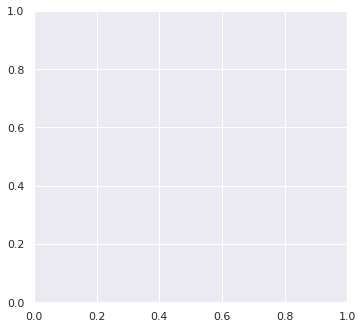

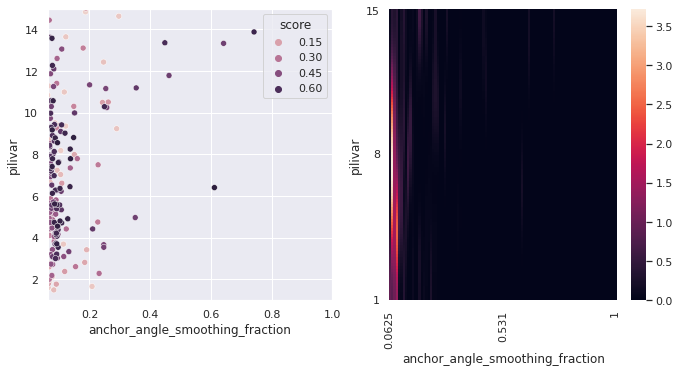

In [25]:
# palette = sns.color_palette("viridis", as_cmap=True)
fig, ax = plt.subplots()
pdata = pd.DataFrame(posterior, anchor, pilivar)
fig, axes = plt.subplots(1,2,figsize=(10,5))
ax = axes[1]
sns.heatmap(pdata, ax=ax)
_p1, _p2 = projection
def _heatmap_ax(ax, _bounds):
    xlim, ylim = _bounds
    ax.invert_yaxis()
    # simplify this tick locator business
    ax.set_xticks([0,res//2,res-1])
    ax.set_yticks([0,res//2,res-1])
    ax.set_xticklabels(["{:.3g}".format(x) for x in np.linspace(*xlim, num=3, endpoint=True)])
    ax.set_yticklabels(["{:.3g}".format(x) for x in np.linspace(*ylim, num=3, endpoint=True)])
    ax.set_xlabel(_p1)
    ax.set_ylabel(_p2)
_heatmap_ax(ax, [xlim, ylim])
# scatter
ax = axes[0]
p1, p2 = projection
ax = sns.scatterplot(data=llacc, x=p1, y=p2, hue="score", ax=ax)
ax.set_xlim(bounds[ix])
ax.set_ylim(bounds[iy])


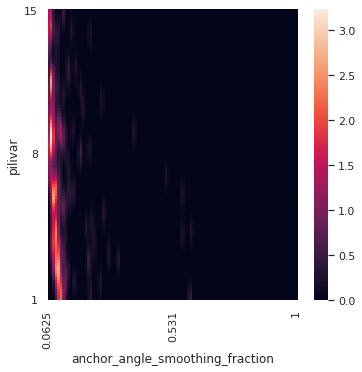

In [26]:
# Must be after the anchor/pilivar basis is defined
# statsmodels = False
statsmodels = True
if statsmodels:
    X1, X2 = np.meshgrid(anchor, pilivar)
    result = 3*dens.pdf([X1.ravel(), X2.ravel()])
    _grid = result.reshape([100,100])
    ax = sns.heatmap(_grid)
    _heatmap_ax(ax, [xlim, ylim])



In [27]:
# compare bandwidth settings
# print("me", [mod_bw_settings[par]["set"] for par in projection])
# print("statmodels", dens.bw)
# check normalization 
# https://coderedirect.com/questions/502920/integrating-2d-samples-on-a-rectangular-grid-using-scipy
check = False
if check: # normalization
    from scipy.integrate import simps
    print("pdf integrates to ", simps(simps(posterior, anchor), pilivar))
    line = np.sum(posterior,axis=0)
    plt.plot(anchor, line)
    estimate1d = np.sum(anchor*line)/np.sum(line)
    print("simple anchor parameter estimate {:.2g}".format(estimate1d))
# we used this estimate to skip ahead and do abc with the anchor parameter frozen out
# see ~/usb_twitching/run/5bfc8b9/cluster/mc3d_frozen



In [28]:
# ---------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------
# sampling arbitrary distributions

In [29]:
# sample this pdf
# 1. interpolate to a smooth function
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp2d.html
# 2. check the interpolation
# 3. sampling
# https://stackoverflow.com/questions/49211126/efficiently-sample-from-arbitrary-multivariate-function

In [30]:
# pinky library does give any better result than our brute force sampling
if verbose:
    # someone has done the work for us so lets use it
    sys.path.append(join(notedir, "lib/pinky"))
    from pinky import Pinky
    ix, iy = [parnames.index(par) for par in projection]
    xlim, ylim = bounds[ix], bounds[iy]
    extent = np.array([*xlim, *ylim])
    print(extent)
    pink = Pinky(P=posterior, extent=extent)
    x0 = np.array([0.2,10.0])
    samples = pink.sample(1000, r=1)
    x, y = samples.T
    ax = sns.kdeplot(x, y, levels=10, fill=True, bw_adjust=0.8)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title("resampled")

 pinky is fast but the sampling doesn't seem all that accurate
 the denisty tapers the y-boundary and seems unnecessarily smoothed
 although that could be seaborn.kdeplot

bbox [1.0, 15.0, 0.0625, 1.0]


Text(0.5, 1.0, 'recovered from interpolation')

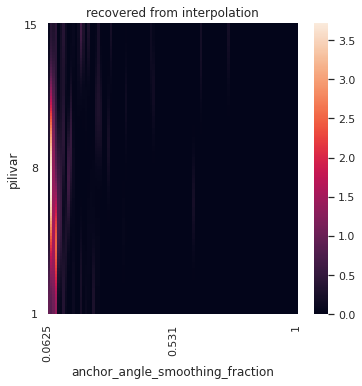

In [31]:
# for our own sampling implementation we need to interpolate the posterior distribution
from numpy.random import uniform
import scipy.interpolate
# image data is stored in numpy row order arrays 
# hence the 0th axis in the array is the y axis
# we choose to construct interpolated functions which accept (y,x) as arguments rather than (x,y)
bbox = [*ylim, *xlim]
print("bbox", bbox)
# For whatever reason scipy recommends RectBivariateSpline for rectangular samples. Lets trust them.
target_density = scipy.interpolate.RectBivariateSpline(pardata[1],pardata[0],posterior, 
    bbox=bbox)
    
# test the interpolation
show = np.zeros(posterior.shape)
for index, x in np.ndenumerate(X1):
    y = X2[index]
    show[index]  = target_density(y,x)
ax = sns.heatmap(show)
_heatmap_ax(ax, [xlim,ylim])
ax.set_title("recovered from interpolation")
# its good


nsamples 1979


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'brute force resampled')

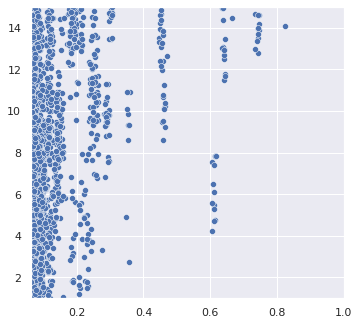

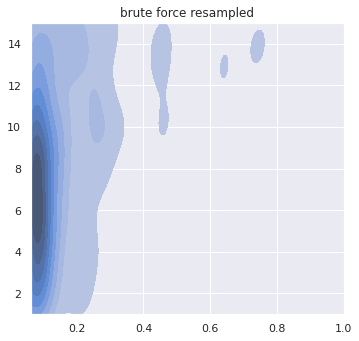

In [32]:
# test our brute force sampling
from abcimplement import force_sample_target

# maximum (from sampled pdf)
zlim = (0, np.max(posterior))
xt, yt = force_sample_target(target_density, [xlim, ylim, zlim])
print("nsamples", len(xt))
fig, ax = plt.subplots()
ax  = sns.scatterplot(x=xt,y=yt)
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
fig, ax = plt.subplots()
ax = sns.kdeplot(xt,yt, fill=True, ax=ax)
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
ax.set_title("brute force resampled")
# works well


In [33]:
# ----------------------------------------------------------------
# ----------------------------------------------------------------
# mc3d with fixed anchor parameter = 0.17
# see rejectionabc.py

